# LVIT Analysis Comparison (Arctic Gel vs Sample)

# Instructions

## Before Using this Program
#### First trial after connecting LVIT: "SAP05_VoltageSetUp"
Upload the Arduino file "Test_VMeasurement.ino" on the Arduino software. Wait to see if data is recorded, then Close out the program.
    Subsequent trials can ignore this step.

#### First trial of each day: "SAP05_Calibration"
Use python file "LVIT Calibration Test". Replace the port name with the port the LVIT is attached to. Replace the heights with the values of the calibration blocks. Run the program and place the corresponding block when prompted. Shut down the Kernel.  

#### Run all trials of Arctic Gel and Lygos SAP using "SAP05_AbsorptionSpeedByLVIT" before running this program

## Main Analysis Program: "LVIT  Analysis Comparison"


In [1]:
import serial
import time
from datetime import datetime
import pdb
import csv
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

## Set Up

In [14]:
#Devaelop Area to use in approximating volume.
radius = 30 #in cm
area = np.pi*radius**2

color_list = ['b','g','r','c','m','y']

experiment = input("Type in date of test (mm-dd-yy):\n")
#experiment = 39

a_runs = input('How many Arctic Gel runs were performed?\n')
l_runs = input('How many Sample runs were performed?\n')

sample_brand = input("Type in the Sample brand:")

brands = ['A', sample_brand[0].upper()]
brandnames = ['Arctic Gel', 'Lygos',sample_brand]

Type in date of test (mm-dd-yy):
02-29-24
How many Arctic Gel runs were performed?
1
How many Sample runs were performed?
2
Type in the Sample brand:Walmart


In [3]:
def closest_value(input_list, input_value):
 
  arr = np.asarray(input_list)
 
  i = (np.abs(arr - input_value)).argmin()
 
  return arr[i]

## Main Analysis Loop

Make sure to have all relevant files in the same folder as this file. 

Make the filename consistent with the file produced in LVIT Test in the format filename = (brand)_(experiment)_run.csv. Change those variables to be consistent with the data set.

## Arctic Gel Analysis

A_1_02-29-24.csv
T-20 = 244.197 when Mass = 20.208291592467695

Average T-20 = 244 s
Average Max Absorption Rate = 0.543 cc/s


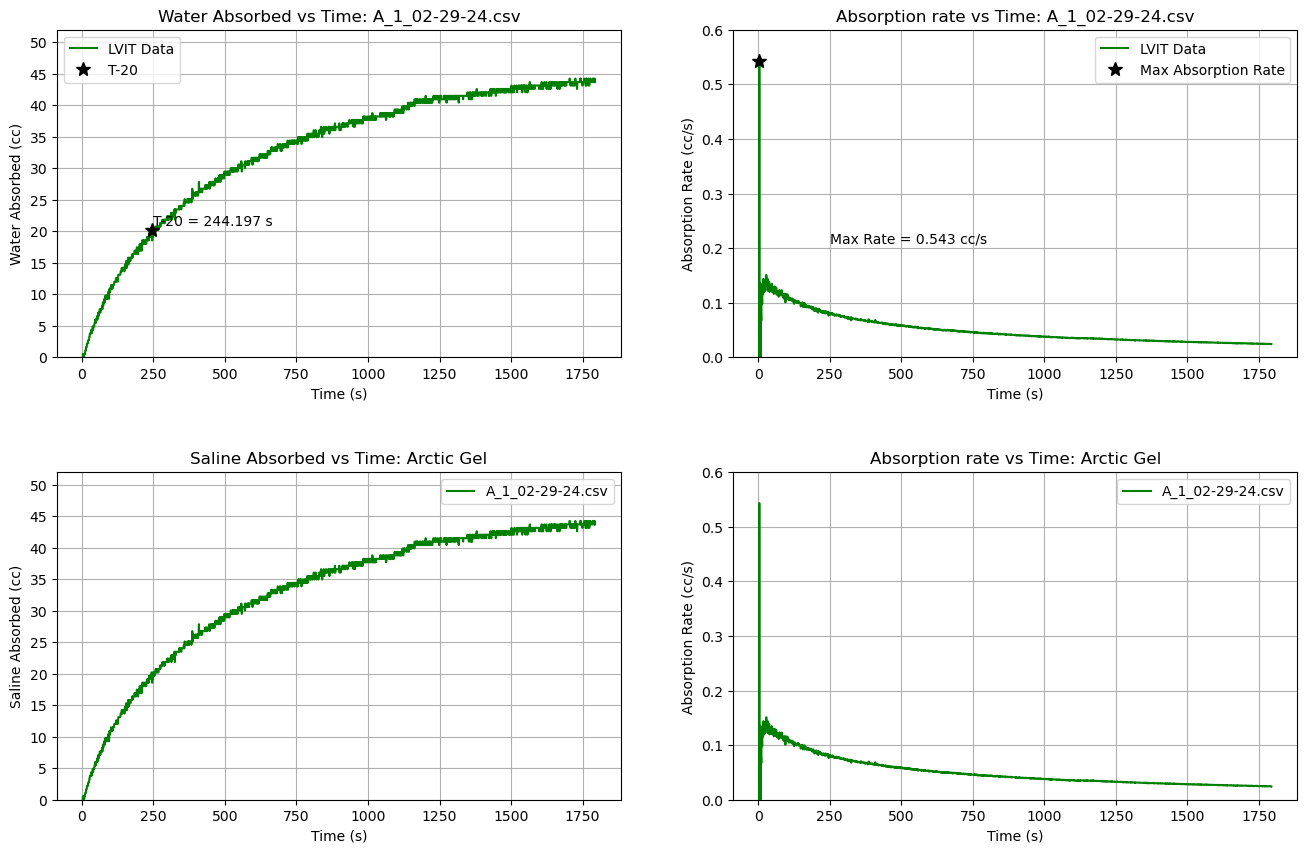

In [6]:
#Set Up Brand Specifics
brand = "a"
brandname = brandnames[brands.index(brand.upper())]


#Set Up File Format
brand =  f"{brand.upper()}"

#Set Up Figures: Rows = # of trials + a compilation, Columns = Mass data + Rate Data
fig, axs = plt.subplots(nrows=(int(a_runs)+1), ncols=2, figsize=(16, int(a_runs)*10))
axs = axs.flatten()
fig.subplots_adjust(hspace=.35)
yp2 = np.linspace(0,(50),11)
yv2 = np.linspace(0,(.25),6)

#Set up variables for mean analysis
displacements = []
max_rates = []
max_times = []
absorptions = []
M20s = []
T20s = []   

#Main Loop    
for run in range(1,int(a_runs) +1):
    #Set up variables for each trial.
    Time = []
    Position = []
    Mass = []
    
    #Set filename, then cycle through each line to get the time, position, and mass data. The original files have
    #the full data with original voltage content.
    filename = f"{brand}_{run}_{experiment}.csv"
    #filename = f"{brand}{experiment}_{run}.csv"
    print(filename)
    with open(filename, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # skip header row
        for row in csv_reader:
            Time.append(float(row[0]))
            Position.append(float(row[1]))
            Mass.append(float(row[2]))
        
    
    #Calculate the change in mass and time.
    dM = [i - Mass[0] for i in Mass[1:]]
    dTm = [i - Time[0] for i in Time[1:]]

    # Calculate mass_rate (change in mass over change in time)
    Mass_Rate = [dM[i]/dTm[i]  for i in range(len(dM))]
    Mass_Rate = [0] + Mass_Rate
    Tv = Time[:len(Mass_Rate)]

    #Develop the total displacement and add to global variable.
    displacement = max(Position) - min(Position)
    displacements.append(displacement)

    #Develop the total absorption and add to global variable.
    absorption = max(Mass) - min(Mass)
    absorptions.append(absorption)
    
    #Develop the max rate after 5s to eliminate artifacting and develop the time where it occurs, 
    #then add to global variable.
    max_rate = max(Mass_Rate)
    max_time = Time[Mass_Rate.index(max_rate)]
    max_rates.append(max_rate)
    max_times.append(max_time)
    
    #Approximate which value is closest to 20 cc in the mass data, then use it to find the time it occurs.
    M20 = closest_value(Mass,20)
    T20 = Time[Mass.index(M20)]
    print(f"T-20 = {T20} when Mass = {M20}")
    M20s.append(M20)
    T20s.append(T20)


    #Plots
    
    run_index = (run - 1)*2
    
    #Individual Mass and Rate plots for each trial.
    mass = run_index 
    axs[mass].plot(Time, Mass,color_list[run], label='LVIT Data',markersize=1.5)
    axs[mass].plot(T20,M20,'k*', label='T-20', markersize=10)
    axs[mass].set_xlabel('Time (s)')
    axs[mass].set_ylabel('Water Absorbed (cc)')
    axs[mass].set_title('Water Absorbed vs Time: {0}'.format(filename))
    axs[mass].set_yticks(yp2)
    axs[mass].set_ylim(0,52)
    axs[mass].grid(True)
    axs[mass].legend()
    axs[mass].text(250, 21, "T-20 = {0} s".format(T20))
    
    rate = run_index + 1
    axs[rate].plot(Time, Mass_Rate,color_list[run], label='LVIT Data',markersize=1.5)
    axs[rate].plot(max_time,max_rate,'k*', label='Max Absorption Rate', markersize=10)
    axs[rate].set_xlabel('Time (s)')
    axs[rate].set_ylabel('Absorption Rate (cc/s)')
    axs[rate].set_title('Absorption rate vs Time: {0}'.format(filename))
    #axs[rate].set_yticks(yv2)
    axs[rate].set_ylim(0,.6)
    axs[rate].grid(True)
    axs[rate].legend()
    axs[rate].text(250, .21, "Max Rate = {0} cc/s".format(round(max_rate,3)))
    
    
    #Composite Mass and Rate plots for the brand.
    mass = int(a_runs)*2
    axs[mass].plot(Time, Mass,color_list[run], label='{0}'.format(filename),markersize=1.5)
    axs[mass].set_xlabel('Time (s)')
    axs[mass].set_ylabel('Saline Absorbed (cc)')
    axs[mass].set_title('Saline Absorbed vs Time: {0}'.format(brandname))
    axs[mass].set_yticks(yp2)
    axs[mass].set_ylim(0,52)
    axs[mass].grid(True)
    axs[mass].legend()
    
    rate = int(a_runs)*2 + 1
    axs[rate].plot(Time, Mass_Rate,color_list[run], label='{0}'.format(filename),markersize=1.5)
    axs[rate].set_xlabel('Time (s)')
    axs[rate].set_ylabel('Absorption Rate (cc/s)')
    axs[rate].set_title('Absorption rate vs Time: {0}'.format(brandname))
    #axs[rate].set_yticks(yp2)
    axs[rate].set_ylim(0,.6)
    axs[rate].grid(True)
    axs[rate].legend()
    
A_T20 = round(np.mean(T20s))
A_MaxRate = round(np.mean(max_rates),3)
print('\nAverage T-20 = {0} s'.format(round(np.mean(T20s))))
print('Average Max Absorption Rate = {0} cc/s'.format(round(np.mean(max_rates),3)))

## Sample Analysis

W_1_02-29-24.csv
T-20 = 204.68 when Mass = 20.034733627117298
W_2_02-29-24.csv
T-20 = 241.142 when Mass = 20.051635051748345

Average T-20 = 223 s
Average Max Absorption Rate = 0.102 cc/s


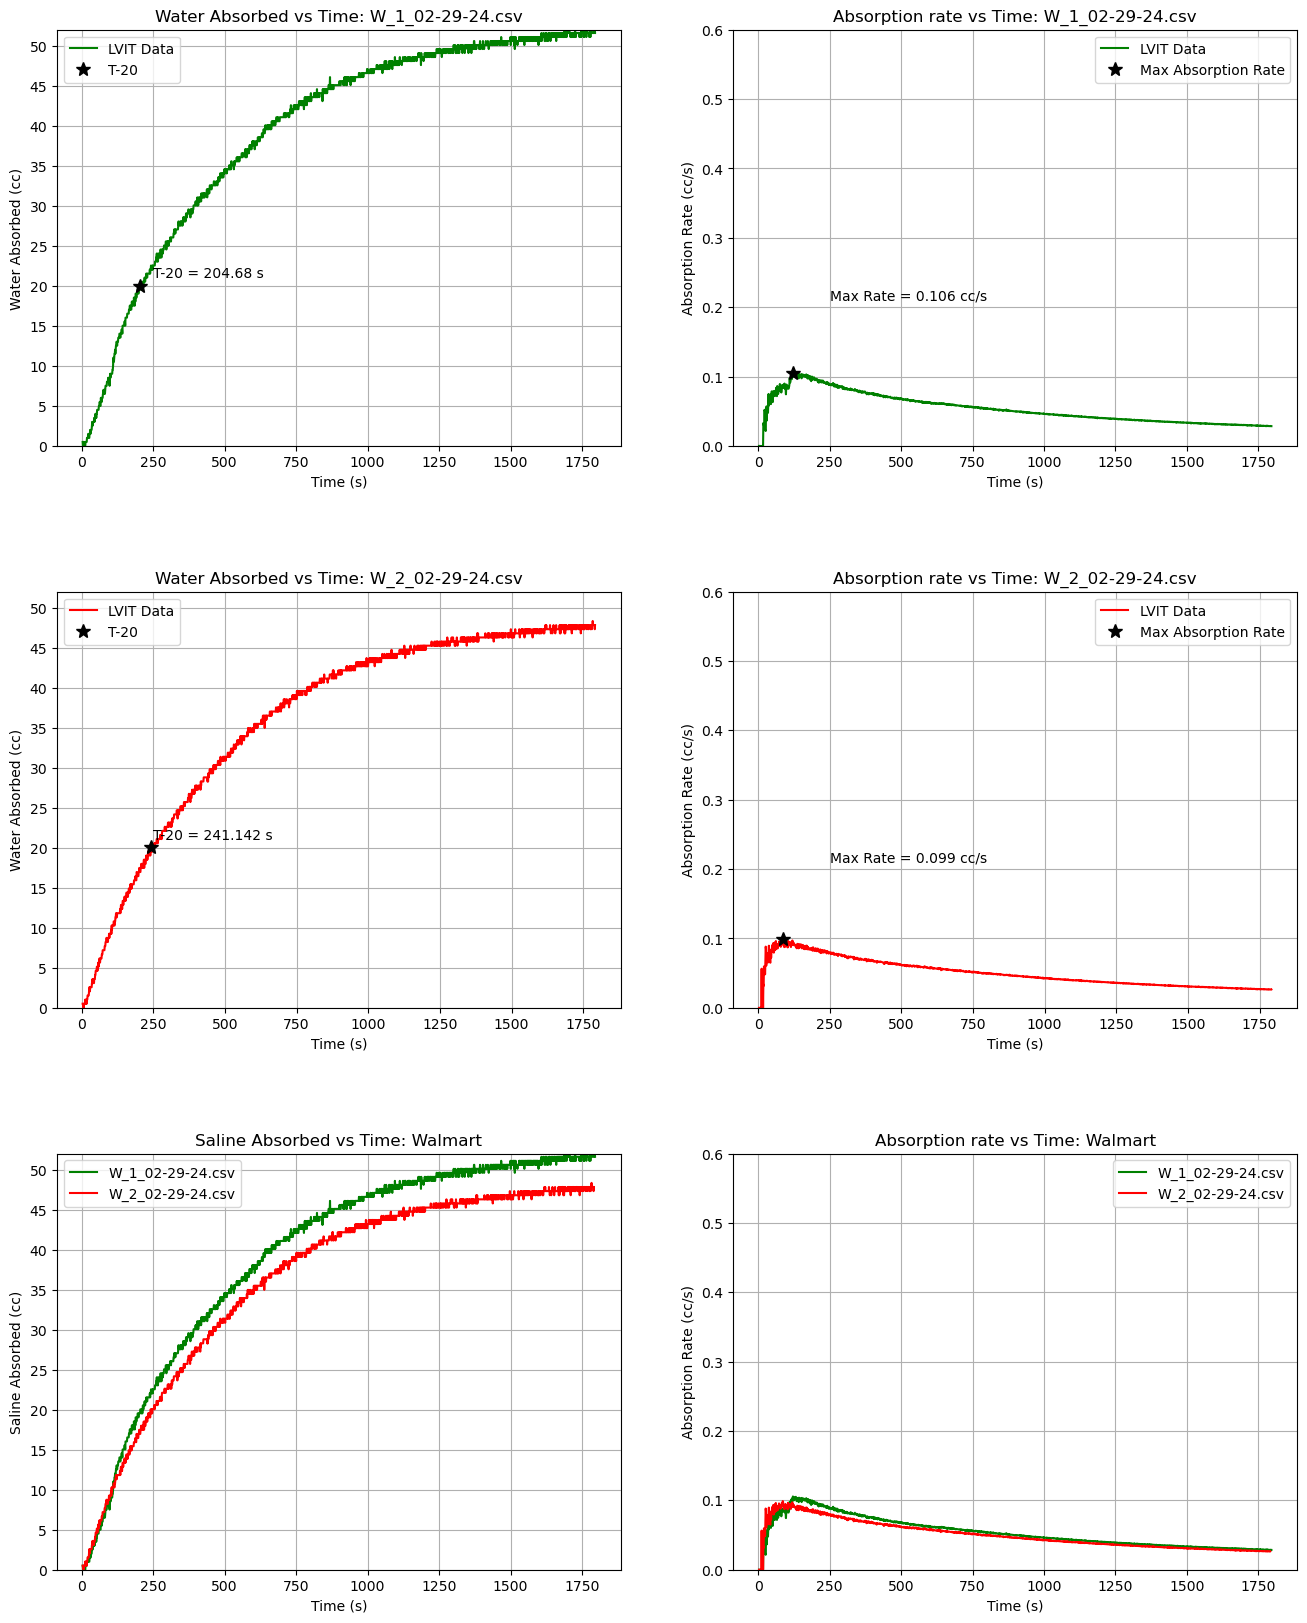

In [9]:
#Set Up Brand Specifics
brand = sample_brand[0]
brandname = brandnames[brands.index(brand.upper())]


#Set Up File Format
brand =  f"{brand.upper()}"

#Set Up Figures: Rows = # of trials + a compilation, Columns = Mass data + Rate Data
fig, axs = plt.subplots(nrows=(int(l_runs)+1), ncols=2, figsize=(16, int(l_runs)*10))
axs = axs.flatten()
fig.subplots_adjust(hspace=.35)
yp2 = np.linspace(0,(50),11)
yv2 = np.linspace(0,(.25),6)

#Set up variables for mean analysis
displacements = []
max_rates = []
max_times = []
absorptions = []
M20s = []
T20s = []   

#Main Loop    
for run in range(1,int(l_runs) +1):
    #Set up variables for each trial.
    Time = []
    Position = []
    Mass = []
    
    #Set filename, then cycle through each line to get the time, position, and mass data. The original files have
    #the full data with original voltage content.
    filename = f"{brand}_{run}_{experiment}.csv"
    #filename = f"{brand}{experiment}_{run}.csv"
    print(filename)
    with open(filename, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # skip header row
        for row in csv_reader:
            Time.append(float(row[0]))
            Position.append(float(row[1]))
            Mass.append(float(row[2]))
        
    
    #Calculate the change in mass and time.
    dM = [i - Mass[0] for i in Mass[1:]]
    dTm = [i - Time[0] for i in Time[1:]]

    # Calculate mass_rate (change in mass over change in time)
    Mass_Rate = [dM[i]/dTm[i]  for i in range(len(dM))]
    Mass_Rate = [0] + Mass_Rate
    Tv = Time[:len(Mass_Rate)]

    #Develop the total displacement and add to global variable.
    displacement = max(Position) - min(Position)
    displacements.append(displacement)

    #Develop the total absorption and add to global variable.
    absorption = max(Mass) - min(Mass)
    absorptions.append(absorption)
    
    #Develop the max rate after 5s to eliminate artifacting and develop the time where it occurs, 
    #then add to global variable.
    max_rate = max(Mass_Rate)
    max_time = Time[Mass_Rate.index(max_rate)]
    max_rates.append(max_rate)
    max_times.append(max_time)
    
    #Approximate which value is closest to 20 cc in the mass data, then use it to find the time it occurs.
    M20 = closest_value(Mass,20)
    T20 = Time[Mass.index(M20)]
    print(f"T-20 = {T20} when Mass = {M20}")
    M20s.append(M20)
    T20s.append(T20)


    #Plots
    
    run_index = (run - 1)*2
    
    #Individual Mass and Rate plots for each trial.
    mass = run_index 
    axs[mass].plot(Time, Mass,color_list[run], label='LVIT Data',markersize=1.5)
    axs[mass].plot(T20,M20,'k*', label='T-20', markersize=10)
    axs[mass].set_xlabel('Time (s)')
    axs[mass].set_ylabel('Water Absorbed (cc)')
    axs[mass].set_title('Water Absorbed vs Time: {0}'.format(filename))
    axs[mass].set_yticks(yp2)
    axs[mass].set_ylim(0,52)
    axs[mass].grid(True)
    axs[mass].legend()
    axs[mass].text(250, 21, "T-20 = {0} s".format(T20))
    
    rate = run_index + 1
    axs[rate].plot(Time, Mass_Rate,color_list[run], label='LVIT Data',markersize=1.5)
    axs[rate].plot(max_time,max_rate,'k*', label='Max Absorption Rate', markersize=10)
    axs[rate].set_xlabel('Time (s)')
    axs[rate].set_ylabel('Absorption Rate (cc/s)')
    axs[rate].set_title('Absorption rate vs Time: {0}'.format(filename))
    #axs[rate].set_yticks(yv2)
    axs[rate].set_ylim(0,.6)
    axs[rate].grid(True)
    axs[rate].legend()
    axs[rate].text(250, .21, "Max Rate = {0} cc/s".format(round(max_rate,3)))
    
    
    #Composite Mass and Rate plots for the brand.
    mass = int(l_runs)*2
    axs[mass].plot(Time, Mass,color_list[run], label='{0}'.format(filename),markersize=1.5)
    axs[mass].set_xlabel('Time (s)')
    axs[mass].set_ylabel('Saline Absorbed (cc)')
    axs[mass].set_title('Saline Absorbed vs Time: {0}'.format(brandname))
    axs[mass].set_yticks(yp2)
    axs[mass].set_ylim(0,52)
    axs[mass].grid(True)
    axs[mass].legend()
    
    rate = int(l_runs)*2 + 1
    axs[rate].plot(Time, Mass_Rate,color_list[run], label='{0}'.format(filename),markersize=1.5)
    axs[rate].set_xlabel('Time (s)')
    axs[rate].set_ylabel('Absorption Rate (cc/s)')
    axs[rate].set_title('Absorption rate vs Time: {0}'.format(brandname))
    #axs[rate].set_yticks(yp2)
    axs[rate].set_ylim(0,.6)
    axs[rate].grid(True)
    axs[rate].legend()
    
S_T20 = round(np.mean(T20s))
S_MaxRate = round(np.mean(max_rates),3)
print('\nAverage T-20 for {0} = {0} s'.format(round(np.mean(T20s))))
print('Average Max Absorption Rate = {0} cc/s'.format(round(np.mean(max_rates),3)))

## Comparison Analysis

A_1_02-29-24.csv
T-20 = 244.197 when Mass = 20.208291592467695
W_1_02-29-24.csv
T-20 = 204.68 when Mass = 20.034733627117298

Arctic Gel T-20 = 244 s
 Sample T-20 = 223 s
 Difference = -21 s


Arctic Gel Max Rate = 0.543 s
 Sample Max Rate = 0.102 s
 Difference = -0.44100000000000006 s


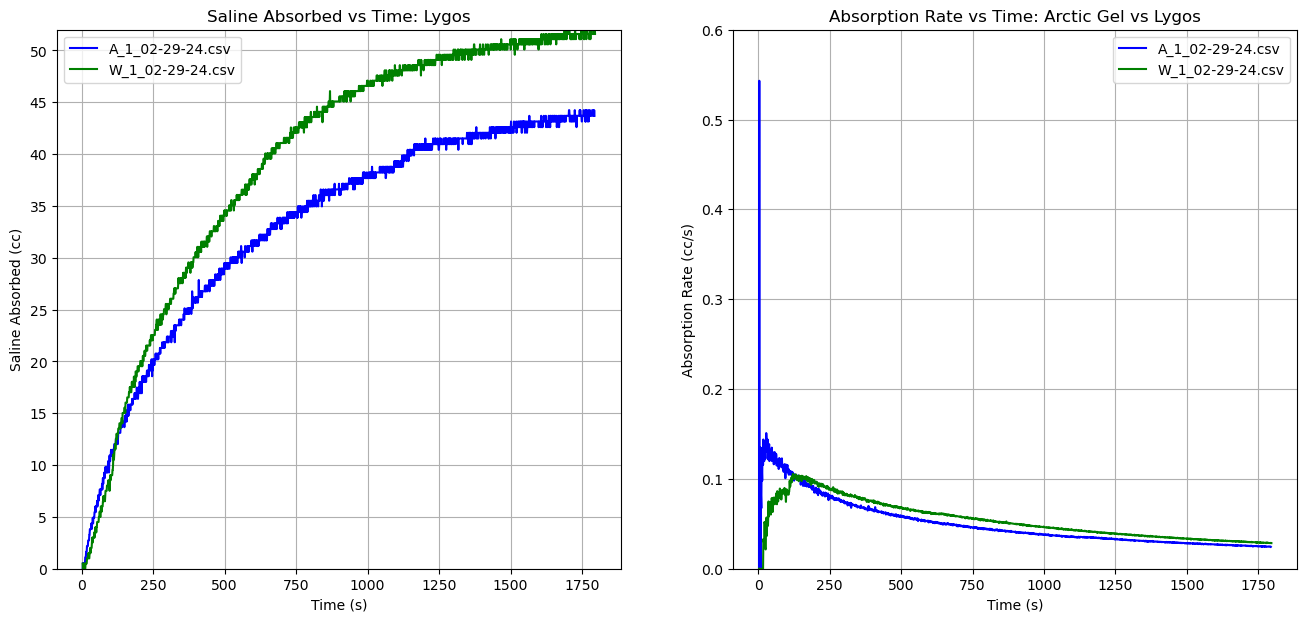

In [19]:

runs = a_runs 

#Set Up Figures: Rows = # of trials + a compilation, Columns = Mass data + Rate Data
fig, axs = plt.subplots(nrows=(1), ncols=2, figsize=(16, 7))
axs = axs.flatten()
fig.subplots_adjust(hspace=.35)
yp2 = np.linspace(0,(50),11)
yv2 = np.linspace(0,(.25),6)

#Set up variables for mean analysis
displacements = []
max_rates = []
max_times = []
absorptions = []
M20s = []
T20s = []   

#Main Loop    
for Brand in brands:
    brandname = brandnames[brands.index(Brand.upper())]
    for run in range(1,int(a_runs) +1):
        #Set up variables for each trial.
        Time = []
        Position = []
        Mass = []

        #Set filename, then cycle through each line to get the time, position, and mass data. The original files have
        #the full data with original voltage content.
        #filename = f"{Brand}_{run}_{experiment}.csv"
        filename = f"{Brand}_{run}_{experiment}.csv"
        print(filename)
        with open(filename, 'r') as csv_file:
            csv_reader = csv.reader(csv_file)
            next(csv_reader)  # skip header row
            for row in csv_reader:
                Time.append(float(row[0]))
                Position.append(float(row[1]))
                Mass.append(float(row[2]))


        #Calculate the change in mass and time.
        dM = [i - Mass[0] for i in Mass[1:]]
        dTm = [i - Time[0] for i in Time[1:]]

        # Calculate mass_rate (change in mass over change in time)
        Mass_Rate = [dM[i]/dTm[i]  for i in range(len(dM))]
        Mass_Rate = [0] + Mass_Rate
        Tv = Time[:len(Mass_Rate)]

        #Develop the total displacement and add to global variable.
        displacement = max(Position) - min(Position)
        displacements.append(displacement)

        #Develop the total absorption and add to global variable.
        absorption = max(Mass) - min(Mass)
        absorptions.append(absorption)

        #Develop the max rate after 5s to eliminate artifacting and develop the time where it occurs, 
        #then add to global variable.
        max_rate = max(Mass_Rate)
        max_time = Time[Mass_Rate.index(max_rate)]
        max_rates.append(max_rate)
        max_times.append(max_time)

        #Approximate which value is closest to 20 cc in the mass data, then use it to find the time it occurs.
        M20 = closest_value(Mass,20)
        T20 = Time[Mass.index(M20)]
        print(f"T-20 = {T20} when Mass = {M20}")
        M20s.append(M20)
        T20s.append(T20)


        #Plots

        #Composite Mass and Rate plots for the brand.
        mass = 0
        axs[mass].plot(Time, Mass,color_list[brands.index(Brand)], label='{0}'.format(filename),markersize=1.5)
        axs[mass].set_xlabel('Time (s)')
        axs[mass].set_ylabel('Saline Absorbed (cc)')
        axs[mass].set_title('Saline Absorbed vs Time: {0}'.format(brandname))
        axs[mass].set_yticks(yp2)
        axs[mass].set_ylim(0,52)
        axs[mass].grid(True)
        axs[mass].legend()

        rate = 1
        axs[rate].plot(Time, Mass_Rate,color_list[brands.index(Brand)], label='{0}'.format(filename),markersize=1.5)
        axs[rate].set_xlabel('Time (s)')
        axs[rate].set_ylabel('Absorption Rate (cc/s)')
        axs[rate].set_title('Absorption Rate vs Time: Arctic Gel vs {0}'.format(brandname))
        #axs[rate].set_yticks(yp2)
        axs[rate].set_ylim(0,.6)
        axs[rate].grid(True)
        axs[rate].legend()
    


print('\nArctic Gel T-20 = {0} s\n Sample T-20 = {1} s\n Difference = {2} s\n'.format(A_T20,S_T20,(S_T20-A_T20)))
print('\nArctic Gel Max Rate = {0} s\n Sample Max Rate = {1} s\n Difference = {2} s'.format(A_MaxRate,S_MaxRate,(S_MaxRate-A_MaxRate)))